In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.special import expit
from scipy.special import erf
from scipy.optimize import curve_fit
import datetime

In [5]:
ts = pd.read_csv("../combined/regions_ts.csv")

In [6]:
base=np.datetime64('2019-12-31')

ts['Date'] = pd.to_datetime(ts['Date'])

ts['diff']= ts['Date']-base
ts['day'] = ts['diff']/np.timedelta64(1,'D')
ts['day'] = ts['day'].astype(int)

ts = ts.rename(columns={'Total Cases': 'Confirmed'})


In [7]:
ts.Date.max()

Timestamp('2020-03-29 00:00:00')

In [8]:
# aggregate by date
ts = ts.groupby(['Date', 'day', 'Region']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])
tsAll = ts.groupby(['Date', 'day']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])


In [9]:
def sigmoid(x, x0, yM, xf):
    y = expit((x-x0)*xf)*yM   # logistic
    #y1 = np.arctan((x-x0)*xf)/np.pi*yM + yM/2 # arctan
    #y2 = np.tanh((x-x0)*xf2)*yM/2 + yM/2 # tanh
    #y3 = erf((x-x0)*xf3)*yM/2 + yM/2 # erf
    return y

def startP0(x,y):
    return [(x.max()+x.min())/2, y.max(), 1]


In [10]:
def regionData(region, metric='Confirmed'):
    if region!=None:
        cdata = ts[(ts['Region']==region)]
    else:
        cdata = tsAll
    x = cdata.day.values
    y = cdata[metric].values
    return x,y

In [11]:
def estimate(region):
    x,y=regionData(region)

    try:
        p0 = startP0(x,y)
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))
    except:
        popt = np.array([np.nan,np.nan,np.nan])
        perr = popt

    return popt, perr


In [12]:
estimate('Lombardia')

(array([8.12825878e+01, 5.06639267e+04, 1.77268219e-01]),
 array([3.02778581e-01, 1.12818941e+03, 3.97231979e-03]))

In [63]:
def fitPlot(region, name=None, metric='Confirmed'):
    try:
        x,y=regionData(region, metric)

        if name==None:
            name=str(region)

        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Sigmoid fit for '+metric+' in '+name)

        try:
            p0 = startP0(x,y)
            popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
            perr = np.sqrt(np.diag(pcov))

            x_reg = np.linspace(min(x), 2 * max(x) - min(x), 100)
            y_reg = sigmoid(x_reg, *popt)
            y_low = sigmoid(x_reg, popt[0]+perr[0], popt[1]-perr[1]*2, *(popt[2:]+perr[2:]))
            y_high= sigmoid(x_reg, popt[0]-perr[0], popt[1]+perr[1]*2, *(popt[2:]-perr[2:]))

            plt.plot(x_reg, y_reg, linewidth=3.0, label='fit')
            plt.fill_between(x_reg, y_low, y_high, alpha=0.5, label='95% conf')
        except:
            print('No fit for '+name)
            
        plt.plot(x, y, 'o', label='cases')

        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+name)

In [64]:
def estPlot(region, name=None, metric='Confirmed'):
    if name==None:
        name=str(region)

    yMFit = pd.DataFrame()

    x,y=regionData(region, metric)

    for n in range(1,len(x)):
        try:
            sx = x[:n]
            sy = y[:n]
            p0 = startP0(sx,sy)
            popt, pcov = curve_fit(sigmoid, sx, sy, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            err = perr[1]
            yM = popt[1]
        except:
            #print('No fit for day ',n)
            yM = np.nan
            err = np.nan
        yMFit = yMFit.append({'d':x[n], 'est':yM, 'error': err, 'cases': y[n]}, ignore_index=True)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Estimation over time for '+metric+' in '+name)

    plt.plot(yMFit.d, yMFit.est, linewidth=2.0, label='est')
    yLow=yMFit.est-yMFit.error*2
    yHigh=yMFit.est+yMFit.error*2
    plt.fill_between(yMFit.d, yLow, yHigh, alpha=0.5, label='95% conf')
    plt.plot(x, y, 'o', label='cases')

    plt.ylim(-10, min(yMFit.cases.max()*3, max(yMFit.cases.max(),yMFit.est.max()*1.4)))
    plt.xlim(yMFit.d.min()-2, yMFit.d.max()+2)
    plt.legend(loc='upper left')
    
    plt.show()


In [65]:
def allPlots(region, name=None):
    fitPlot(region,name)
    fitPlot(region,name,'Deaths')
    estPlot(region,name)
    estPlot(region,name,'Deaths')


In [66]:
cRef,cRefErr = estimate('Lombardia')

In [67]:
def plotRegions(regions, metric='Confirmed'):
    try:
        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Compare regions with offset')

        for c in regions:
            try:
                pcov, perr = estimate(c)
                delay=int(pcov[0]-cRef[0])
                yM=pcov[1]
                x,y=regionData(c, metric)
                plt.plot(x-int(pcov[0]), y/yM, linewidth=2.0, label=c+ ' (' +str(delay)+ ' days, max '+str(int(yM/1000))+'k)')
            except:
                print('No fit for '+metric+' in '+c)

        plt.ylim(-0.1, 1.1)
        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+c)

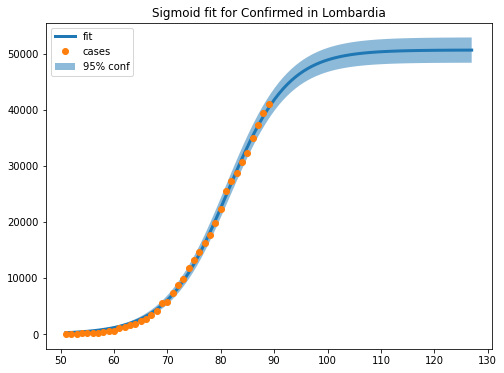

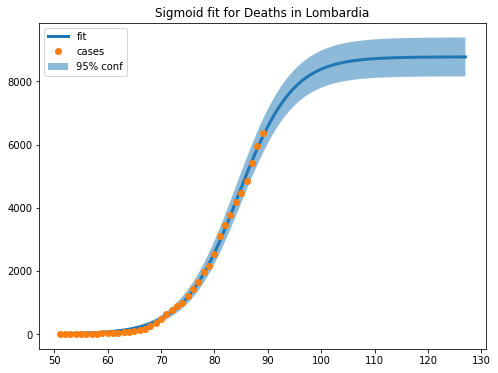

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


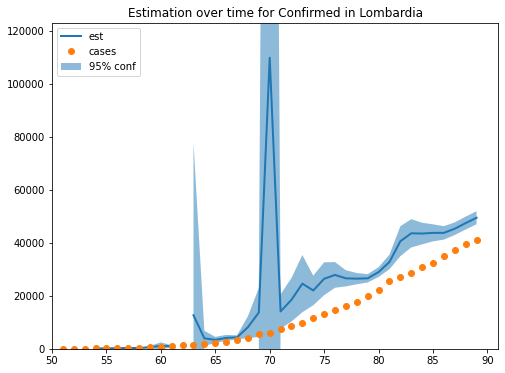

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


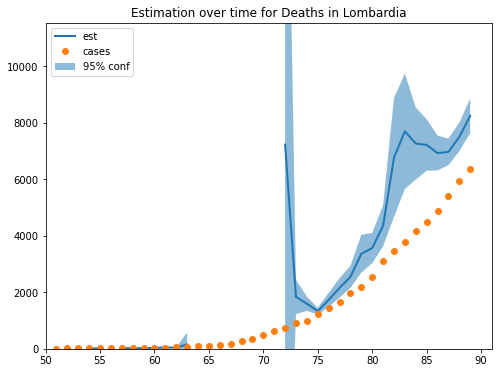

In [68]:
allPlots('Lombardia')

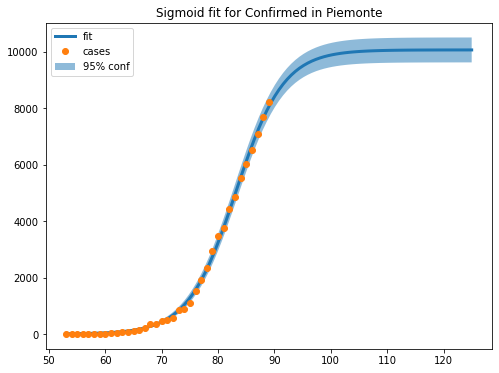

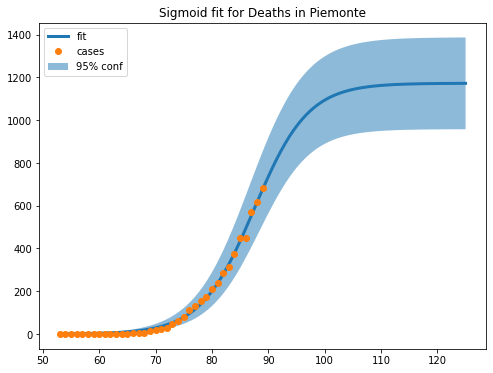

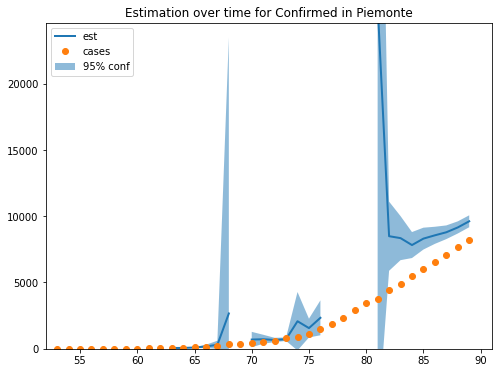

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


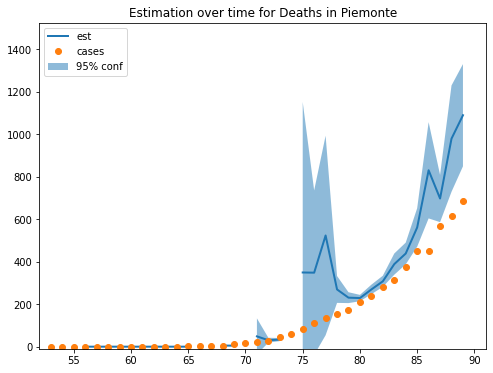

In [69]:
allPlots('Piemonte')

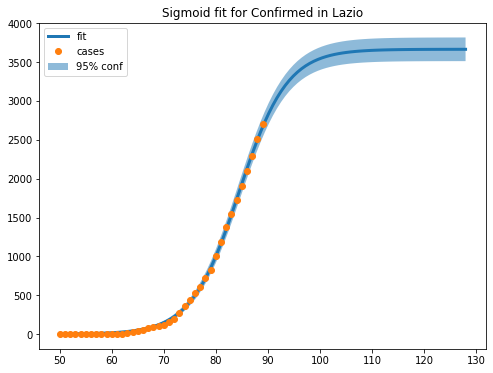

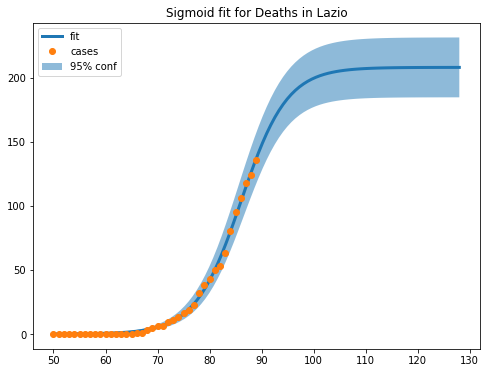

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


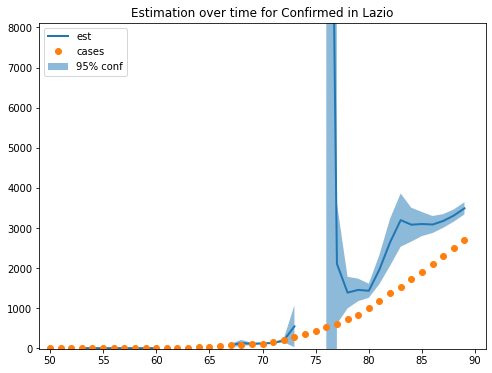

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


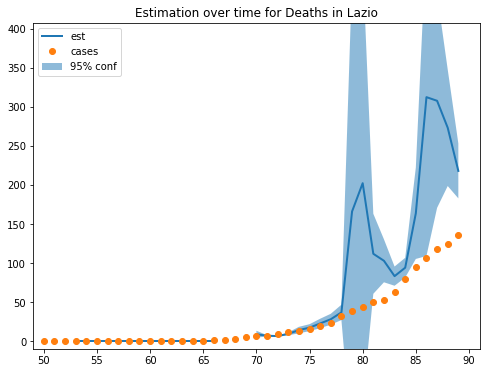

In [70]:
allPlots('Lazio')

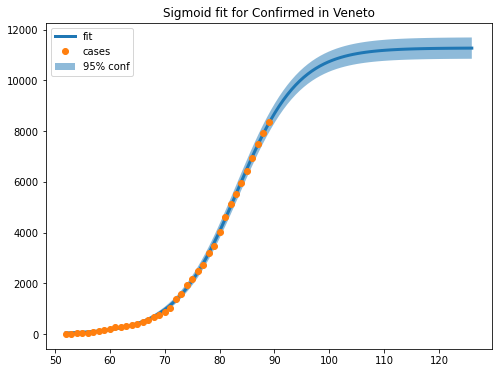

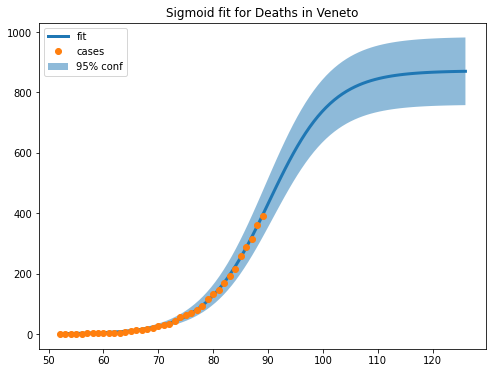

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


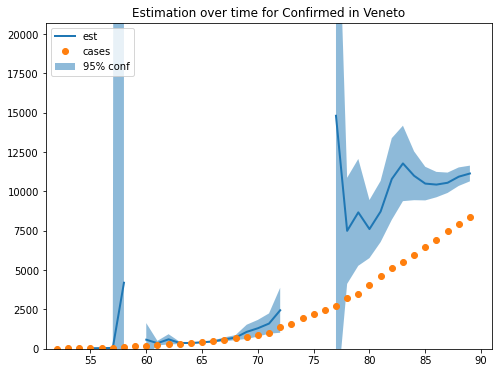

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


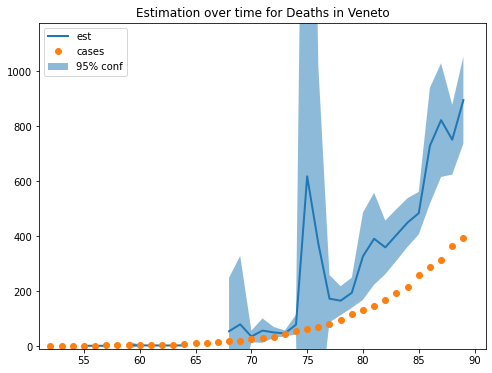

In [71]:
allPlots('Veneto')

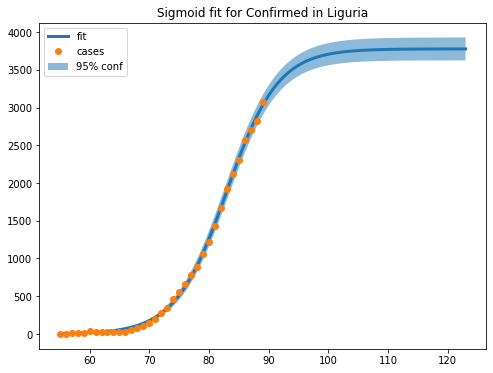

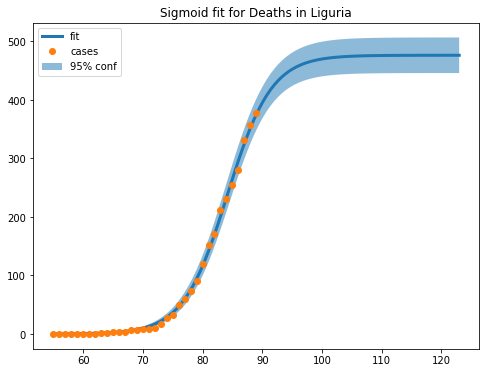

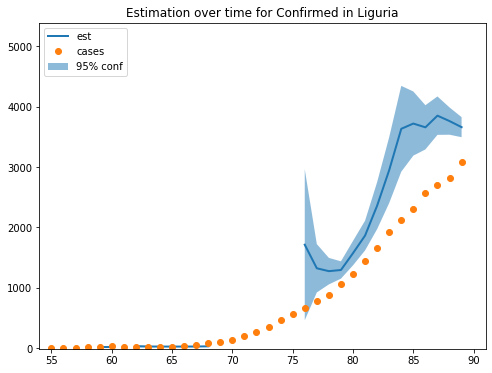

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


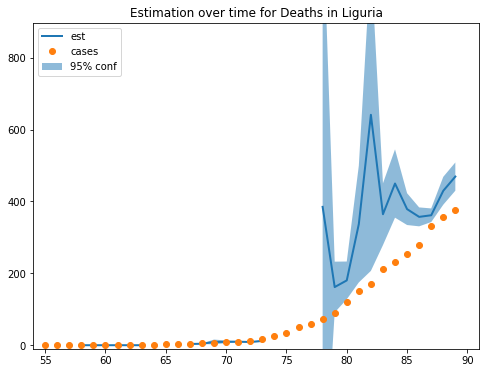

In [72]:
allPlots('Liguria')

In [73]:
regions = ts['Region'].unique()
regions

array(['Lazio', 'Lombardia', 'Veneto', 'Emilia Romagna', 'Piemonte',
       'P.A. Bolzano', "Valle d'Aosta", 'Umbria', 'Toscana', 'Sicilia',
       'Sardegna', 'Puglia', 'P.A. Trento', 'Marche', 'Molise',
       'Basilicata', 'Calabria', 'Campania', 'Abruzzo',
       'Friuli Venezia Giulia', 'Liguria'], dtype=object)

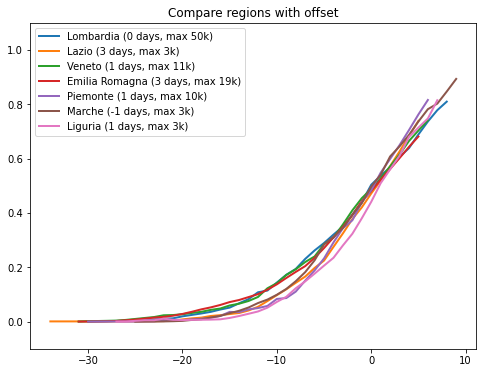

In [74]:
plotRegions(['Lombardia','Lazio','Veneto','Emilia Romagna','Piemonte','Marche','Liguria'])

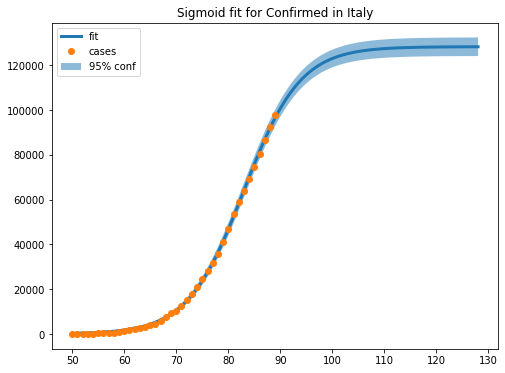

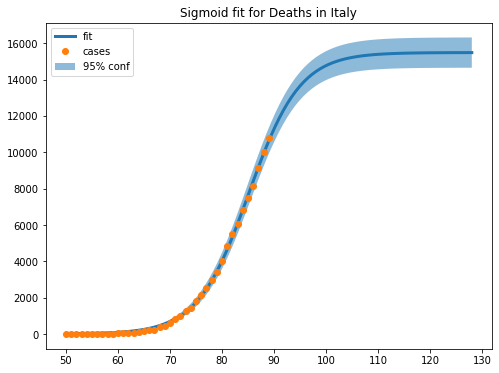

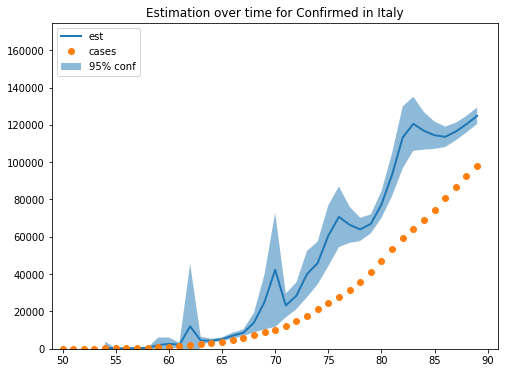

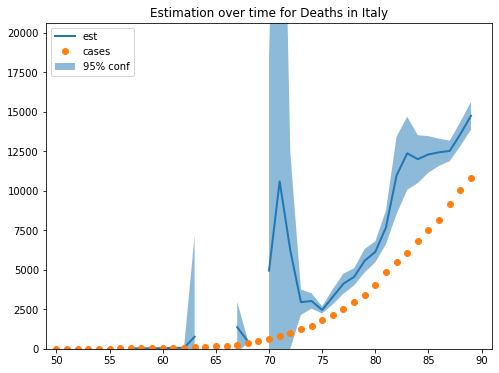

In [75]:
allPlots(None,'Italy')

In [87]:
def flat(region, tolerance):
    pcov, perr = estimate(region)

    x0m = pcov[0]-perr[0]*2
    x0M = pcov[0]+perr[0]*2
    km = pcov[2]-perr[2]*2
    kM = pcov[2]+perr[2]*2
    print(x0m, x0M)
    xm = x0m - np.log(1-tolerance) / kM
    xM = x0M - np.log(1-tolerance) / km


    print(xm, xM)
    print(base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))


In [88]:
flat('Lombardia',0.999)

80.67703065009897 81.88814497386255
117.97333582147206 122.68432540488607
2020-04-26 2020-05-01


In [89]:
flat('Lombardia',0.999)

80.67703065009897 81.88814497386255
117.97333582147206 122.68432540488607
2020-04-26 2020-05-01
